In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15756, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15756 (delta 1), reused 11 (delta 1), pack-reused 15743 (from 1)
Receiving objects: 100% (15756/15756), 6.32 MiB | 10.18 MiB/s, done.
Resolving deltas: 100% (11495/11495), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your env

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [3]:

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
! unzip "/content/drive/MyDrive/Oranges/oranges diesease 5 class.v1i.coco-segmentation.zip"

Archive:  /content/drive/MyDrive/Oranges/oranges diesease 5 class.v1i.coco-segmentation.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
  inflating: test/_annotations.coco.json  
 extracting: test/bgmold3_png.rf.3045be179eed18eddf2088b4e128817d.jpg  
 extracting: test/green1_png.rf.f799ece2a162d9e09427a4d1eaf33f75.jpg  
 extracting: test/green5_png.rf.ef124bb60bdbfe87a0384c2465ed0496.jpg  
 extracting: test/green9_png.rf.b56f388436881bcc8ec7b28cf4bf2684.jpg  
 extracting: test/rot_png.rf.5683669e16d96e442883bdb4b153d808.jpg  
   creating: train/
 extracting: train/S-M-10_png.rf.616aec2f1a40e801b2e6943199ac2c79.jpg  
 extracting: train/S-M-10_png.rf.69e41ef34c193d3d2fa3495c1af81cf9.jpg  
 extracting: train/S-M-10_png.rf.8629a34e233bc18e186d45c644868bb8.jpg  
 extracting: train/S-M-11_png.rf.39348da479929f831b7e94429775e0bd.jpg  
 extracting: train/S-M-11_png.rf.b78d15000a3e1648826acfd5964a2f4e.jpg  
 extracting: train/S-M-11_png.rf.da59

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")


In [6]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

WARNING [08/20 13:40:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 13:40:56 d2.data.datasets.coco]: Loaded 105 images in COCO format from /content/train/_annotations.coco.json


In [7]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

WARNING [08/20 13:40:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/20 13:40:56 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/valid/_annotations.coco.json


In [8]:
from matplotlib import pyplot as plt

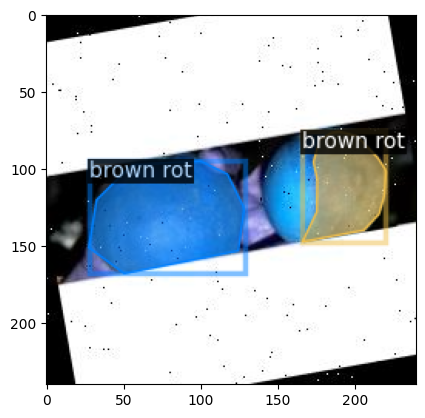

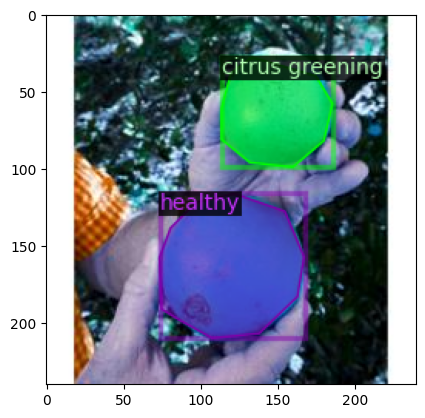

In [9]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [21]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data.transforms import ResizeShortestEdge, RandomFlip, RandomRotation, RandomBrightness, RandomContrast
import os
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# Dataset and Dataloader
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 4

# Model Weights and Training Setup
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4  # Adjust according to GPU capacity
cfg.SOLVER.BASE_LR = 0.001  # Initial learning rate
cfg.SOLVER.MAX_ITER = 2000  # Increase for longer training
cfg.SOLVER.STEPS = []  # Learning rate decay steps

# Fine-tuning strategy: Freeze the backbone, then unfreeze
cfg.MODEL.BACKBONE.FREEZE_AT = 2

# Model Architecture
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # Number of classes in your dataset
cfg.MODEL.DEVICE = 'cuda'  # Ensure you're using GPU for training

cfg.OUTPUT_DIR = "/content/drive/MyDrive/Oranges/FINE TUNED MODELS"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Data Augmentation
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=[
            ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768), max_size=1333, sample_style='choice'),
            RandomFlip(horizontal=True),
            RandomRotation(angle=[-10, 10]),
            RandomBrightness(0.8, 1.2),
            RandomContrast(0.6, 1.4)
        ])
        return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [23]:
import yaml
config_yaml_path = "/content/drive/MyDrive/Oranges/FINE TUNED MODELS/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

[08/20 14:57:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Oranges/FINE TUNED MODELS/model_final.pth ...


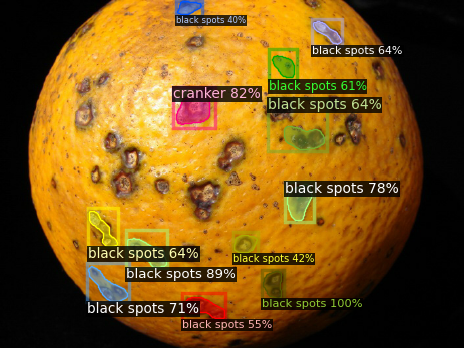

In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


new_im = cv2.imread("/content/Typical-black-spot-lesions-on-Valencia-sweet-orange-caused-by-Guignardia-citricarpa.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])
